Steps to run a future prediction on timeseries data using auto regression, 
1. Load your dataset
2. Convert your date to datetime and set as index
3. Check that your data has no missing value, if it does compute
4. split your data to train and test; the test data is usually the last full year in your dataset
5. plot your data to see the type of pattern if it is trend or seasonal
6. Account for trend component by creating a timestep
7. Account for seasonality by creating month data and convert to dummy variable
8. run a trend-seasonal regression:feature timestep(account for trend) and month dummy variables (account for seasonality)
9. Asses your remainder(or remainder) to see if there is still pattern/time dependence
10. If time dependendce is observe in residue create a lag of the residue to account for the time dependence in the residue
11. To choose the best lag shift run 'ar_select_order' or partial correlation
12. Then remove the NAN rows from your data affet incoporating lagshift column into database
13. Run another regression with feature dataset to include timestep, month dummy and the calculated lag
14. Validate the training data using crossvalidation(this dffers from the crosval use in crosssectional data
15. Evaluate your model using test data, ensure to create the timestep, month dummy and lag for the training data
16. Calculate your r2
17. To predict the future, combine all the dataset and rerun your model


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import ar_select_order, AutoReg


# supressing warnings
import warnings
warnings.filterwarnings('ignore')



# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (24,10)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#load the train_temp csv
temp_train=pd.read_csv('temp_train.csv', parse_dates=['date'], index_col='date')
#temp_train.drop(columns='temp', inplace=True)
temp_train.head()

,temp_c
date,
1970-01-01,-12.8
1970-01-02,-4.9
1970-01-03,-1.4
1970-01-04,-4.4
1970-01-05,-3.0


In [3]:
###add time step
temp_train['timestep'] = list(range(temp_train.shape[0]))
temp_train.head()

,temp_c,timestep
date,,
1970-01-01,-12.8,0
1970-01-02,-4.9,1
1970-01-03,-1.4,2
1970-01-04,-4.4,3
1970-01-05,-3.0,4


In [4]:
#### create month feature in the train data
temp_train['month'] = temp_train.index.month_name()
temp_train.head()

,temp_c,timestep,month
date,,,
1970-01-01,-12.8,0,January
1970-01-02,-4.9,1,January
1970-01-03,-1.4,2,January
1970-01-04,-4.4,3,January
1970-01-05,-3.0,4,January


In [5]:
###one encode the month
temp_train = pd.get_dummies(temp_train, prefix='', prefix_sep='')

temp_train.head()

,temp_c,timestep,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,0,1,0,0,0,0,0,0,0
1970-01-02,-4.9,1,0,0,0,0,1,0,0,0,0,0,0,0
1970-01-03,-1.4,2,0,0,0,0,1,0,0,0,0,0,0,0
1970-01-04,-4.4,3,0,0,0,0,1,0,0,0,0,0,0,0
1970-01-05,-3.0,4,0,0,0,0,1,0,0,0,0,0,0,0


In [6]:
###run a trend-seasonal regression
X =temp_train.drop('temp_c', axis=1)  #create feature
y =temp_train['temp_c']               #create label

m_trend_seasonal = LinearRegression()  ##instantiate model

m_trend_seasonal.fit(X, y)  #fit model with train

temp_train['trend_seasonal'] = m_trend_seasonal.predict(X) #add pred frm trend-season to df

temp_train.head()

,temp_c,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
date,,,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.219373
1970-01-02,-4.9,1,0,0,0,0,1,0,0,0,0,0,0,0,-0.219274
1970-01-03,-1.4,2,0,0,0,0,1,0,0,0,0,0,0,0,-0.219175
1970-01-04,-4.4,3,0,0,0,0,1,0,0,0,0,0,0,0,-0.219076
1970-01-05,-3.0,4,0,0,0,0,1,0,0,0,0,0,0,0,-0.218977


In [7]:
##define function to plot
# custom plot function

def plot_timeseries(df, title="", ylim=True):
    """
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    
    """
    
    df.plot(linestyle='--', marker='o')
    plt.title(title)
    if ylim:
        plt.ylim(ymin=0)
    plt.ylabel("temp in c")
    plt.show()

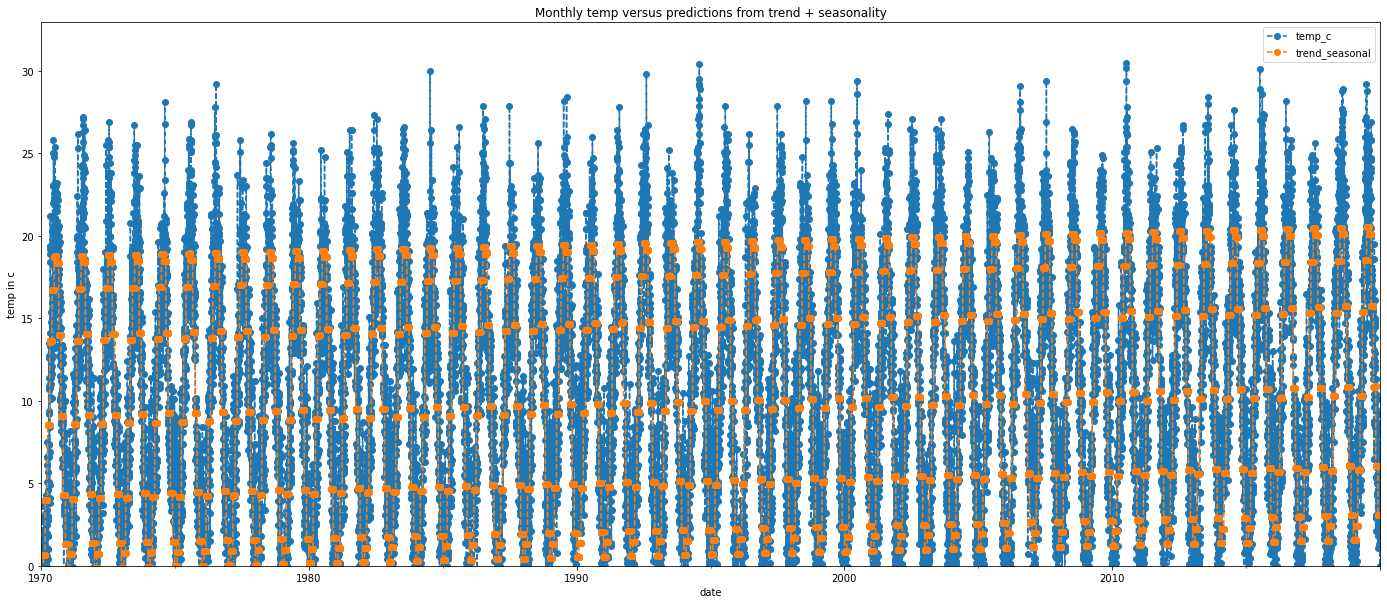

In [8]:
plot_timeseries(temp_train[['temp_c', 'trend_seasonal']], 
                title="Monthly temp versus predictions from trend + seasonality")

In [9]:
###extract the remainder (residue) from trend_seasonal model and add to dataframe
temp_train['remainder'] = temp_train['temp_c'] - temp_train['trend_seasonal']
temp_train.head()

,temp_c,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.219373,-12.580627
1970-01-02,-4.9,1,0,0,0,0,1,0,0,0,0,0,0,0,-0.219274,-4.680726
1970-01-03,-1.4,2,0,0,0,0,1,0,0,0,0,0,0,0,-0.219175,-1.180825
1970-01-04,-4.4,3,0,0,0,0,1,0,0,0,0,0,0,0,-0.219076,-4.180924
1970-01-05,-3.0,4,0,0,0,0,1,0,0,0,0,0,0,0,-0.218977,-2.781023


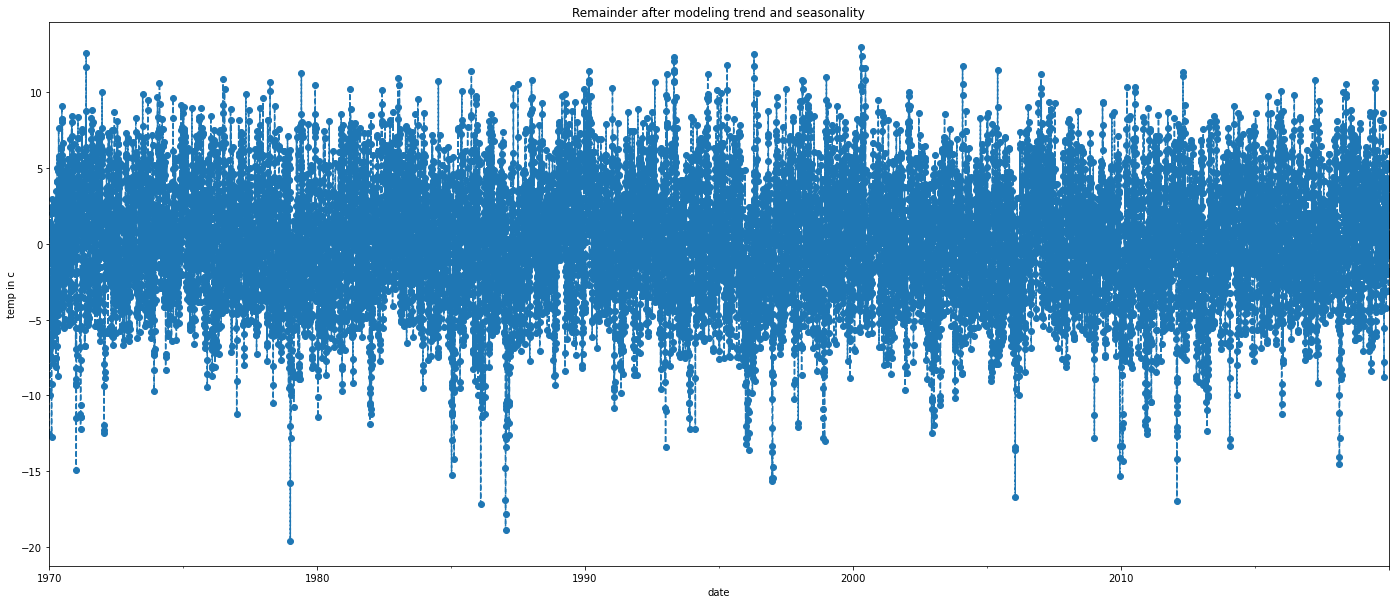

In [10]:
# plot remainder 
plot_timeseries(temp_train['remainder'], title="Remainder after modeling trend and seasonality", ylim=False)

In [11]:
##the remainder shows some trends so lag feature of the remainder is introduce to the model
###calculate the suitable lag size for the remainder

selected_order = ar_select_order(temp_train['remainder'], maxlag = 12)
selected_order.ar_lags

[1, 2, 3]

### lagsize of 3 seams to be the best based on the calculation

In [12]:
##create a new feature in train temp as lag3

temp_train['lag3'] = temp_train['remainder'].shift(3)

temp_train.head()

,temp_c,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag3
date,,,,,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.219373,-12.580627,NaN
1970-01-02,-4.9,1,0,0,0,0,1,0,0,0,0,0,0,0,-0.219274,-4.680726,NaN
1970-01-03,-1.4,2,0,0,0,0,1,0,0,0,0,0,0,0,-0.219175,-1.180825,NaN
1970-01-04,-4.4,3,0,0,0,0,1,0,0,0,0,0,0,0,-0.219076,-4.180924,-12.580627
1970-01-05,-3.0,4,0,0,0,0,1,0,0,0,0,0,0,0,-0.218977,-2.781023,-4.680726


In [13]:
###drop row with NAN value
temp_train.dropna(inplace=True)
temp_train.head()

,temp_c,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag3
date,,,,,,,,,,,,,,,,,
1970-01-04,-4.4,3,0,0,0,0,1,0,0,0,0,0,0,0,-0.219076,-4.180924,-12.580627
1970-01-05,-3.0,4,0,0,0,0,1,0,0,0,0,0,0,0,-0.218977,-2.781023,-4.680726
1970-01-06,-4.7,5,0,0,0,0,1,0,0,0,0,0,0,0,-0.218878,-4.481122,-1.180825
1970-01-07,-7.1,6,0,0,0,0,1,0,0,0,0,0,0,0,-0.218779,-6.881221,-4.180924
1970-01-08,-10.2,7,0,0,0,0,1,0,0,0,0,0,0,0,-0.218680,-9.981320,-2.781023


In [14]:
##train the linear auto-regression  model on the train data
##with feature timestep, dummy months and lag3
X = temp_train.drop(['temp_c', 'trend_seasonal', 'remainder'], axis=1)
y = temp_train['temp_c']

m_tre_sea_lag = LinearRegression()

m_tre_sea_lag.fit(X,y)

temp_train['pred_tre_sea_lag'] = m_tre_sea_lag.predict(X)
temp_train.head()

,temp_c,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag3,pred_tre_sea_lag
date,,,,,,,,,,,,,,,,,,
1970-01-04,-4.4,3,0,0,0,0,1,0,0,0,0,0,0,0,-0.219076,-4.180924,-12.580627,-5.971055
1970-01-05,-3.0,4,0,0,0,0,1,0,0,0,0,0,0,0,-0.218977,-2.781023,-4.680726,-2.308608
1970-01-06,-4.7,5,0,0,0,0,1,0,0,0,0,0,0,0,-0.218878,-4.481122,-1.180825,-0.685975
1970-01-07,-7.1,6,0,0,0,0,1,0,0,0,0,0,0,0,-0.218779,-6.881221,-4.180924,-2.076705
1970-01-08,-10.2,7,0,0,0,0,1,0,0,0,0,0,0,0,-0.218680,-9.981320,-2.781023,-1.427621


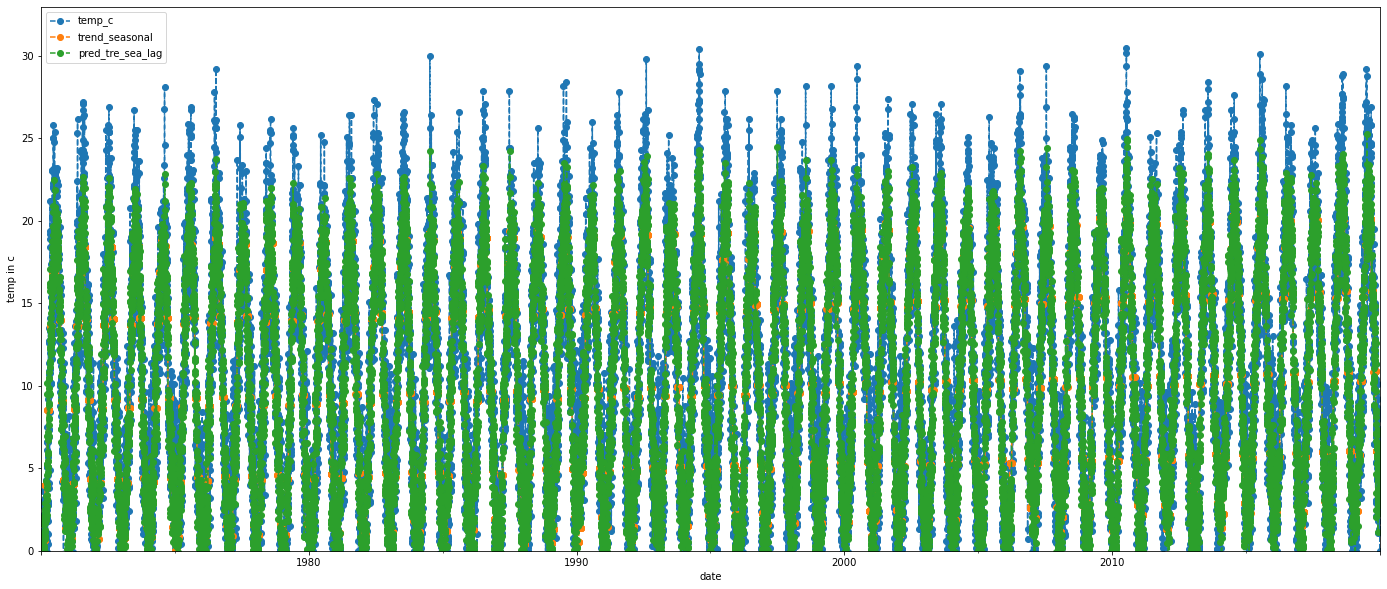

In [15]:
###plot temp_c, trend_season_pred, pred_tre_sea_lag
plot_timeseries(temp_train[['temp_c', 'trend_seasonal', 'pred_tre_sea_lag']])

The prediction from combining the trend, seasonality and lags is better

How to evalutate a Time series
This is done by using crossvalidation made specificlalay for timeseries
the crossval for time series differs from the one for crosssectional data

In [16]:
ts_split = TimeSeriesSplit(n_splits=5) #instatiate the timeseries with num of split
time_cv = ts_split.split(X, y) #fit on the data
estimator = LinearRegression() # instanciate 
r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )
print(r_squared_scores)
print(r_squared_scores.mean())

[0.79712023 0.77438117 0.79730508 0.81793508 0.8004326 ]
0.7974348298639226


import the test data ensure that it has the same data as you have in the training
it must have
1. timestep, continue from the train data, since the test data is a continuation of the train data
2. seasonal data which one encoding of the month data
3. must have the lag3, residue from the trend-seasonal linear regression


In [17]:
####things to do on the test data
temp_test=pd.read_csv('temp_test.csv', parse_dates=['date'], index_col='date')

##drop temp data
#temp_test.drop(columns='temp', inplace=True)  

###create time step, wch must begin from the last one in train data
last_temp_train_timestep = temp_train['timestep'].max()  #
temp_test['timestep'] = list(range(last_temp_train_timestep + 1, len(temp_test) + last_temp_train_timestep + 1))

##create month feature from test data
temp_test['month'] = temp_test.index.month_name()

##make dummy month
temp_test = pd.get_dummies(temp_test, prefix='', prefix_sep='')


In [18]:
###run a trend/seasonality linear regression to predict for new y in test
##u do not need to run a new regression as u av run one before

##create a new X-test with timestep and dummy month that will be use to predict
X_test = temp_test.drop('temp_c', axis=1)

temp_test['trend_seasonal'] = m_trend_seasonal.predict(X_test)


In [19]:
##calculate reminder and lag3 for the remainder
temp_test['remainder'] = temp_test['temp_c'] - temp_test['trend_seasonal']

# Create the lagged variable
temp_test['lag3'] = temp_test['remainder'].shift(3)



In [20]:
##we av to fill the NAN in the test data as we muct predict it too
temp_test.loc['2020-01-01', 'lag3']= temp_train.loc['2019-12-29', 'remainder']
temp_test.loc['2020-01-02', 'lag3']= temp_train.loc['2019-12-30', 'remainder']
temp_test.loc['2020-01-03', 'lag3']= temp_train.loc['2019-12-31', 'remainder']



In [21]:
temp_test.head()

,temp_c,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag3
date,,,,,,,,,,,,,,,,,
2020-01-01,2.7,18262,0,0,0,0,1,0,0,0,0,0,0,0,1.587354,1.112646,-3.096441
2020-01-02,0.9,18263,0,0,0,0,1,0,0,0,0,0,0,0,1.587453,-0.687453,1.403460
2020-01-03,4.6,18264,0,0,0,0,1,0,0,0,0,0,0,0,1.587552,3.012448,2.903361
2020-01-04,4.2,18265,0,0,0,0,1,0,0,0,0,0,0,0,1.587651,2.612349,1.112646
2020-01-05,1.8,18266,0,0,0,0,1,0,0,0,0,0,0,0,1.587750,0.212250,-0.687453


In [22]:
###make prediction based on Lin reg model on timestep, dummy month and lag3
X_test = temp_test.drop(['temp_c','trend_seasonal', 'remainder'], axis=1)

temp_test['pred_tre_sea_lag'] = m_tre_sea_lag.predict(X_test)

temp_test.head()




,temp_c,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag3,pred_tre_sea_lag
date,,,,,,,,,,,,,,,,,,
2020-01-01,2.7,18262,0,0,0,0,1,0,0,0,0,0,0,0,1.587354,1.112646,-3.096441,0.227502
2020-01-02,0.9,18263,0,0,0,0,1,0,0,0,0,0,0,0,1.587453,-0.687453,1.403460,2.313729
2020-01-03,4.6,18264,0,0,0,0,1,0,0,0,0,0,0,0,1.587552,3.012448,2.903361,3.009173
2020-01-04,4.2,18265,0,0,0,0,1,0,0,0,0,0,0,0,1.587651,2.612349,1.112646,2.179107
2020-01-05,1.8,18266,0,0,0,0,1,0,0,0,0,0,0,0,1.587750,0.212250,-0.687453,1.344690


In [23]:
###check the R2 value for the test data
print(r2_score(temp_test['temp_c'], temp_test['trend_seasonal']))  # the score of the trend and season. model

print(r2_score(temp_test['temp_c'], temp_test['pred_tre_sea_lag'])) # score of the full model


0.7504703086360212
0.7738914476296826


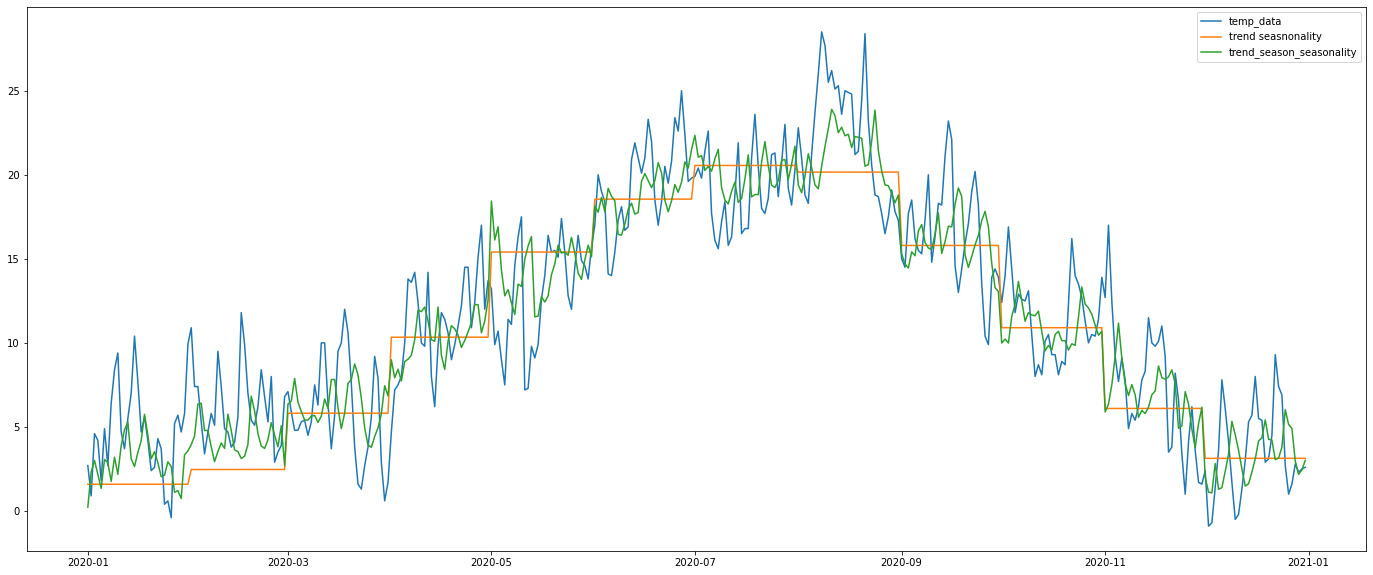

In [24]:
plt.plot(temp_test['temp_c'], label='temp_data')
plt.plot(temp_test['trend_seasonal'], label='trend seasnonality')
plt.plot(temp_test['pred_tre_sea_lag'], label='trend_season_seasonality')
plt.legend()

plt.show()

To do a future prediction it is better to combine all the dataset and use all to retrain model.
